In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

from scipy.stats import trim_mean

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
population_size = 45
num_faces = 32

# Useful Function

In [3]:
def extract_population_response(df, model_idx, col):
    """
    df: the dataframe to extract the responses from
    model_idx: which model we want
    col: the column index of responses we want

    The dataframe was made in the following format
                feat 1 | feat 2 | feat 3 ...
    ------------------------------------------
            |      
    model 0 |
            |
    ------------------------------------------
            |
    model 1 |
            |
    ...
    """
    series = df[col] #the 
    return series.iloc[model_idx*num_faces:(model_idx+1)*num_faces]

In [4]:
def create_mean_df(df, proportiontocut=0.2):
    new_df = pd.DataFrame(0, index=np.arange(population_size), columns=list(df.columns)+["model_idx"])

    for model_idx in range(population_size):
        for col_idx, col in enumerate(df.columns):
            series = extract_population_response(df, model_idx, col)
            ave_response = trim_mean(series, proportiontocut=proportiontocut)
            new_df.at[model_idx, col] = ave_response
            new_df.at[model_idx, 'model_idx'] = model_idx
    return new_df

In [5]:
def pairwise_anova(df, cols, dv, within, subject, correction, detailed):
    results = []
    
    for i in range(len(cols)-1):
        for j in range(i+1, len(cols)):
            temp = df[(df[within]==cols[i]) | (df[within]==cols[j])]
            
            res = pg.rm_anova(data=temp, dv=dv, within=within, subject=subject, 
                  correction=correction, detailed=detailed)

            results.append((cols[i], cols[j], res))
    return results

# Load Data

In [6]:
df_feature_combination = pd.read_csv("feature_combinations_june_14_no_reflections.csv", index_col=0)

In [7]:
df_feature_combination.head()

1 Eye  2 Eyes  1 Eye, Nose  1 Eye, Mouth  2 Eyes, Nose  \
0  15.305  12.525       14.040        13.655        11.990   
1  15.160  13.115       14.175        13.055        12.410   
2  15.295  12.880       13.770        12.335        12.625   
3  15.535  12.650       13.080        12.870        11.990   
4  15.800  13.215       13.810        13.180        11.995   

   1 Eye, Nose, Mouth  Full Face  2 Eyes, Mouth  
0              12.260     10.535         11.495  
1              12.570     11.090         11.410  
2              11.285     11.550         11.885  
3              12.940     11.035         12.375  
4              12.900     10.885         11.680

In [8]:
df_mean_responses = create_mean_df(df_feature_combination, proportiontocut=0)
df_mean_responses.head()

1 Eye     2 Eyes  1 Eye, Nose  1 Eye, Mouth  2 Eyes, Nose  \
0  15.022188  12.824687    13.899688     13.410156     11.995312   
1  15.276094  12.920937    13.996094     13.531719     11.990000   
2  15.157500  12.934375    14.103750     13.735156     12.153750   
3  16.957500  14.315156    15.800625     14.568906     13.484219   
4  14.797187  13.016250    13.762344     13.279219     12.213750   

   1 Eye, Nose, Mouth  Full Face  2 Eyes, Mouth  model_idx  
0           12.506406  10.950937      11.643281          0  
1           12.516250  10.910000      11.661719          1  
2           12.866562  11.240937      11.887969          2  
3           13.712031  11.980937      12.595000          3  
4           12.442813  11.175469      11.829688          4

## Histograms

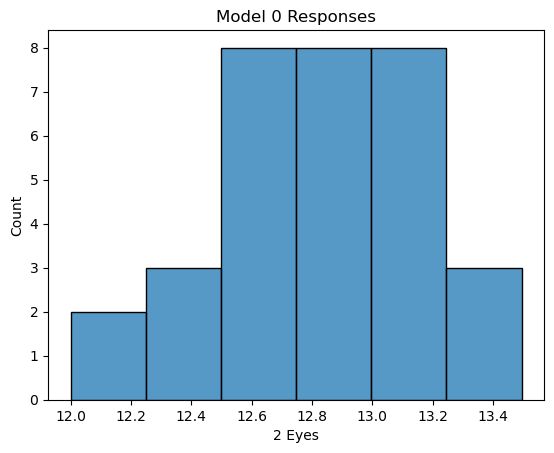

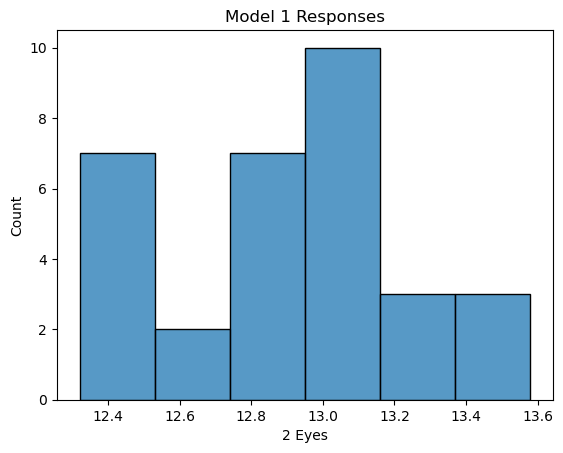

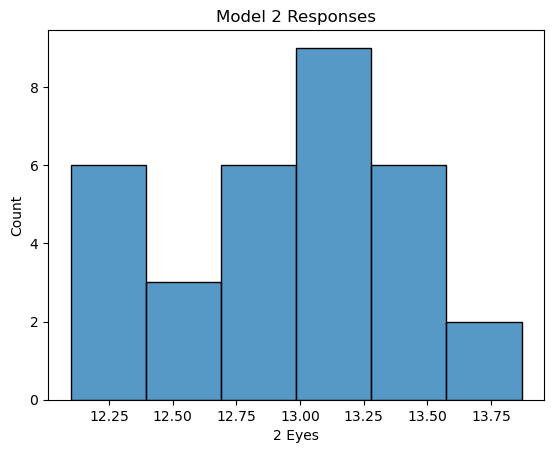

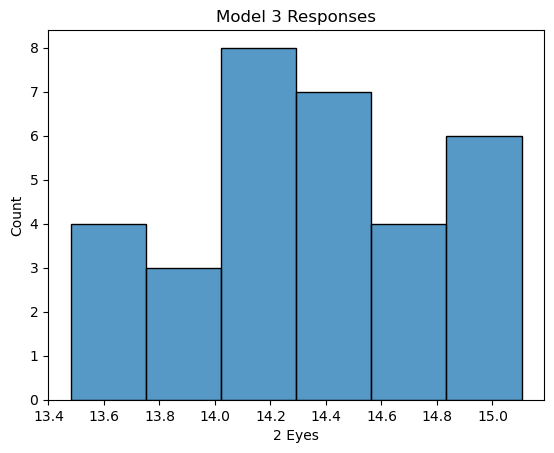

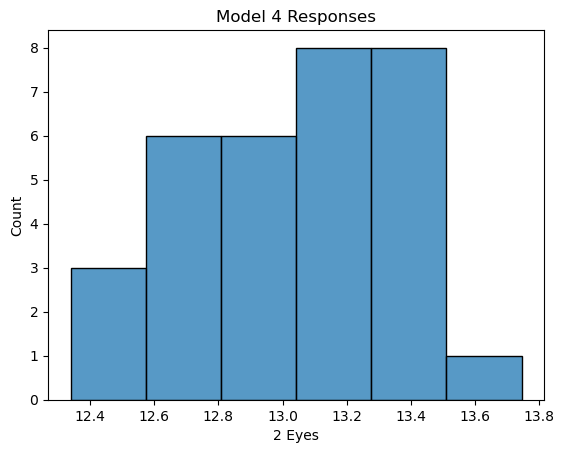

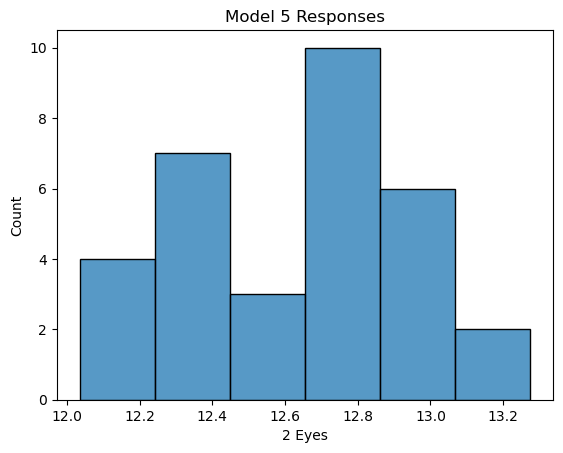

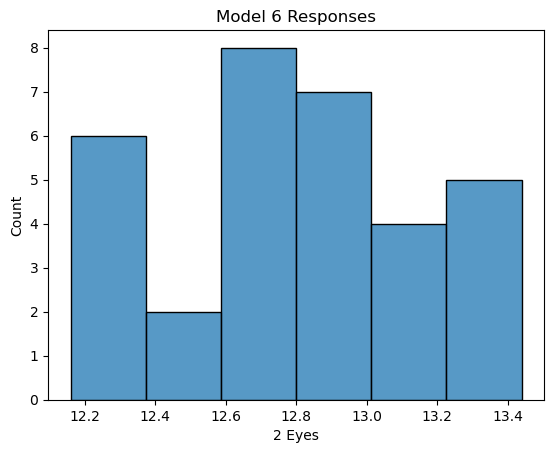

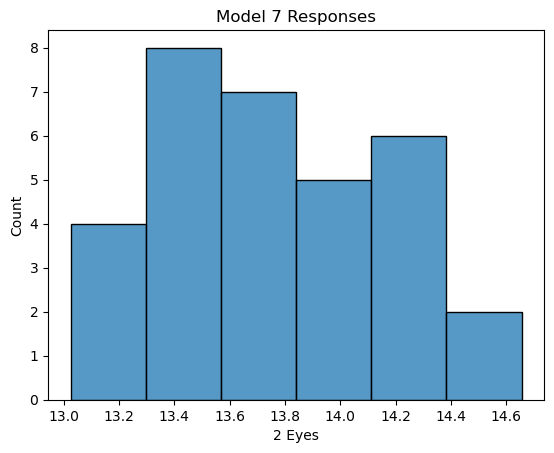

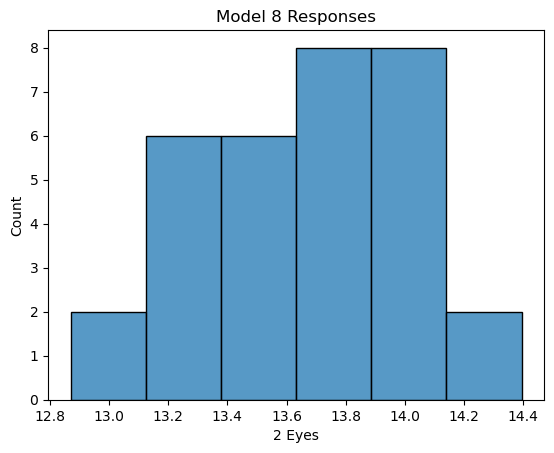

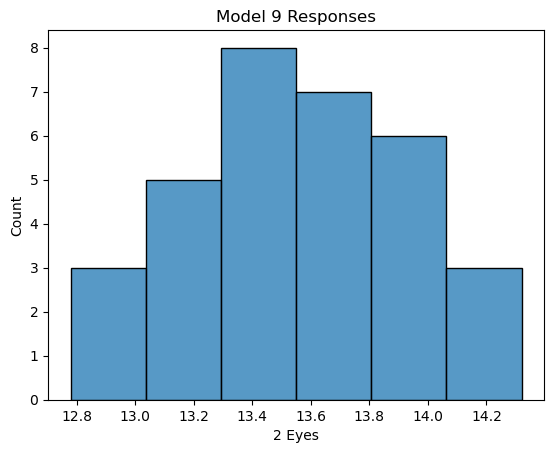

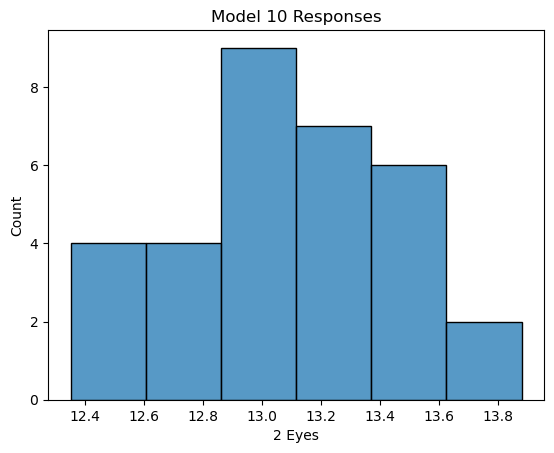

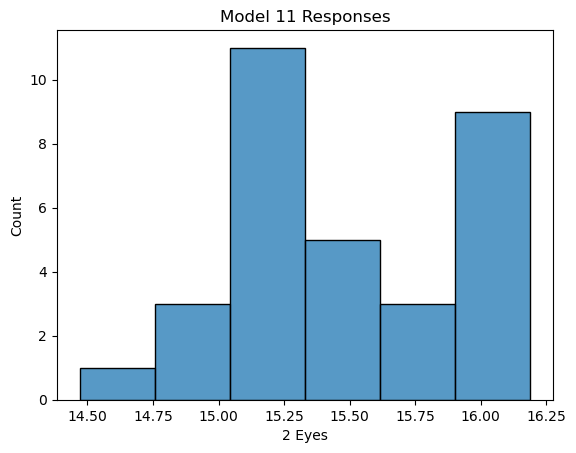

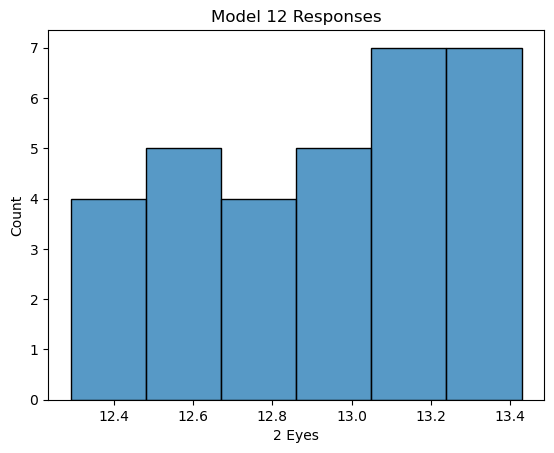

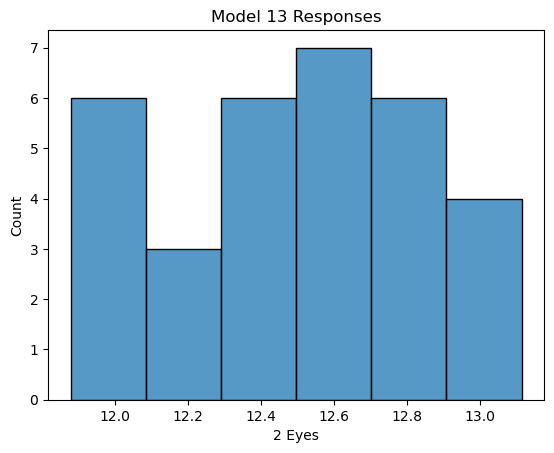

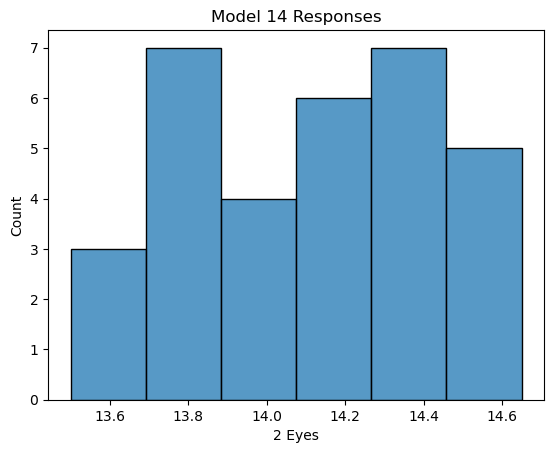

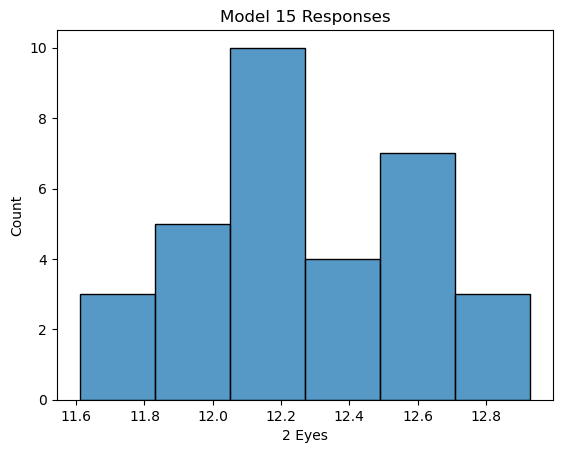

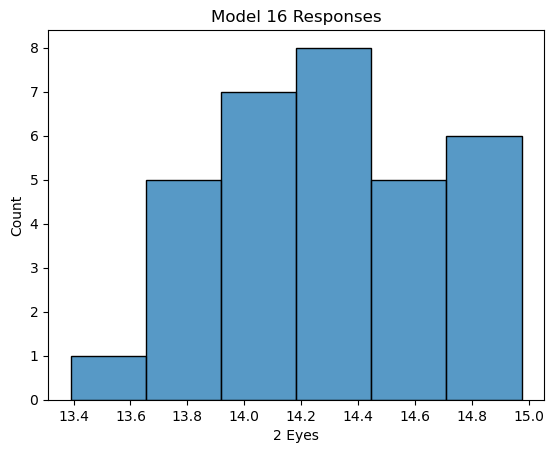

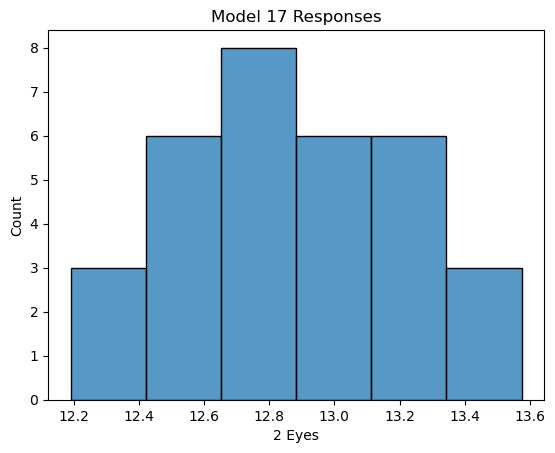

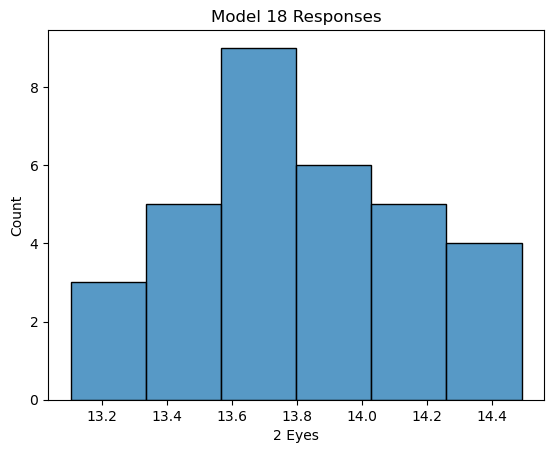

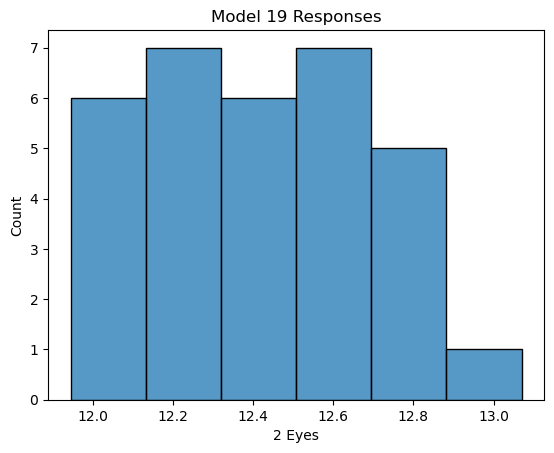

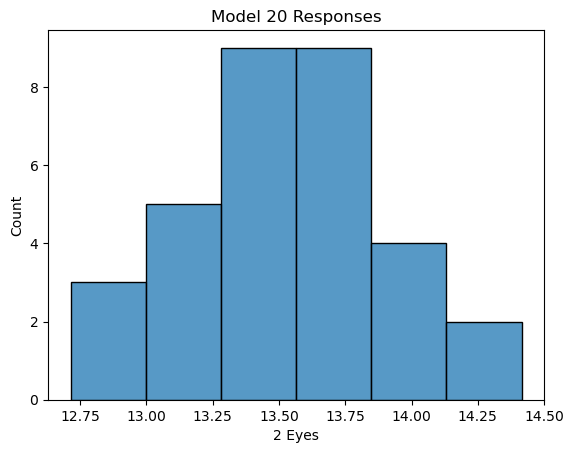

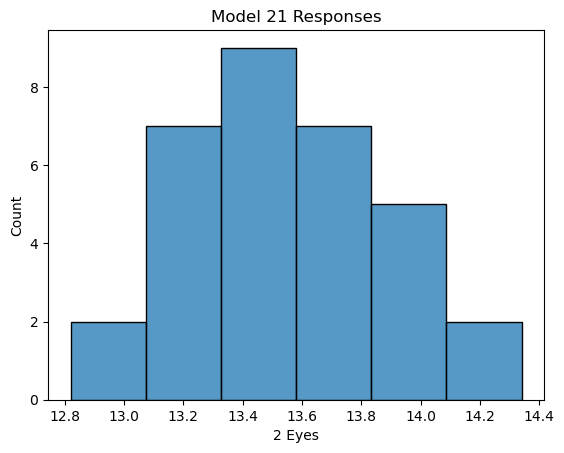

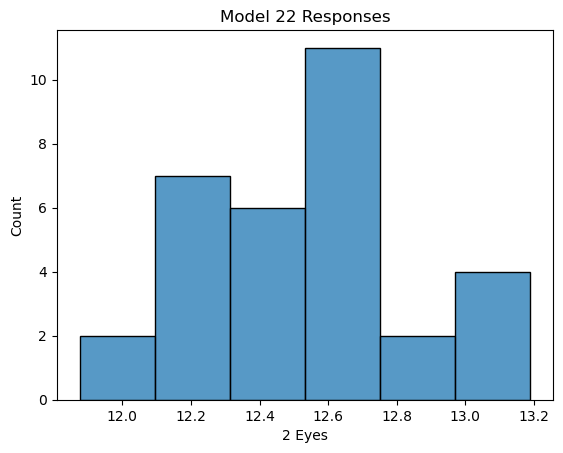

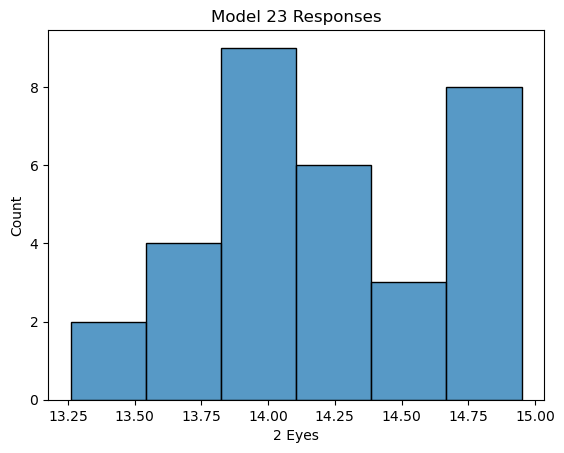

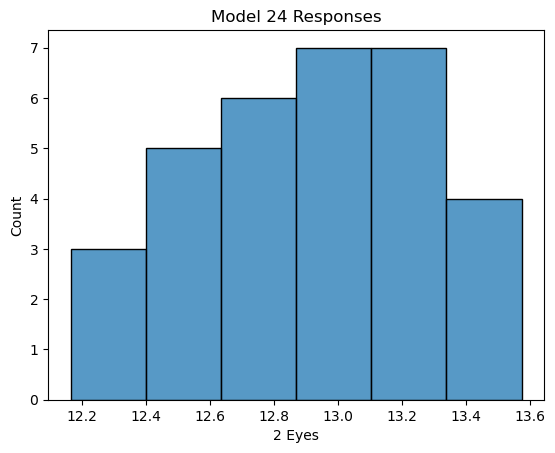

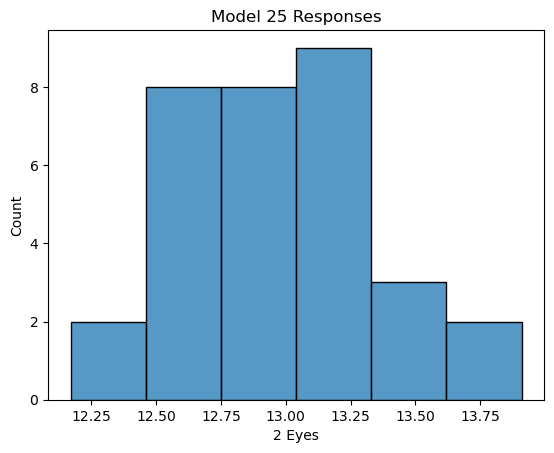

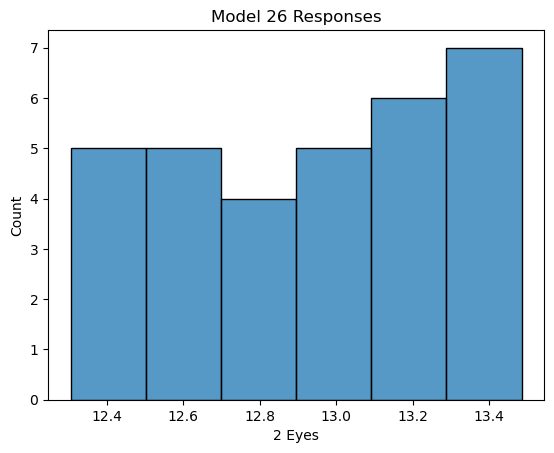

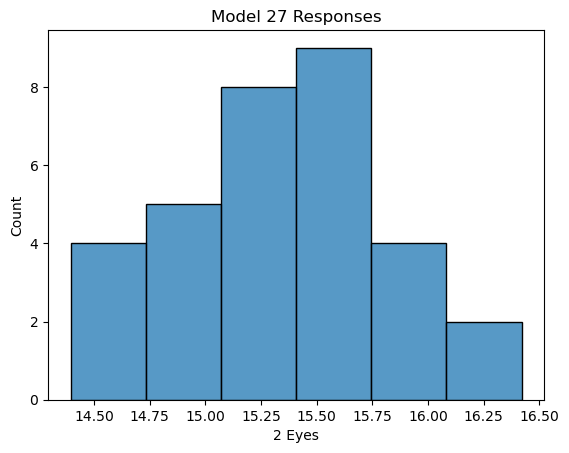

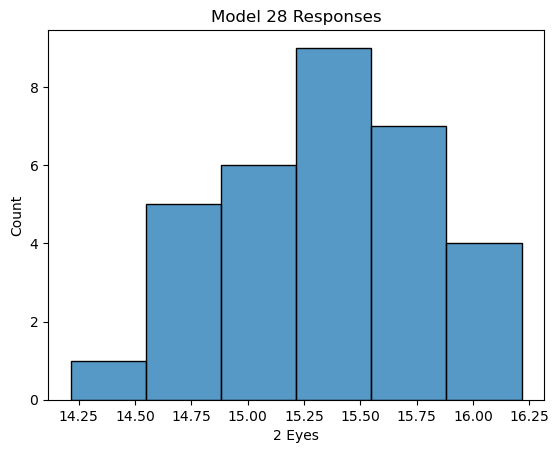

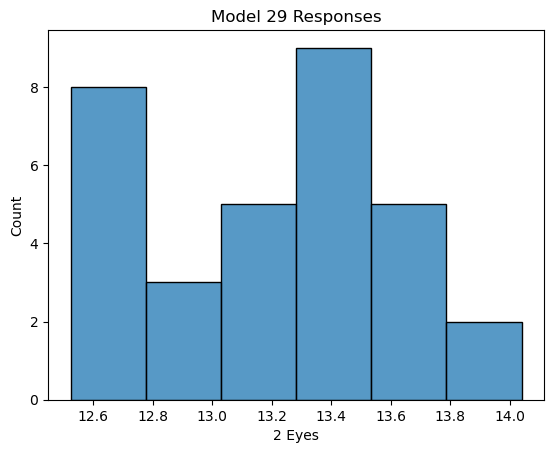

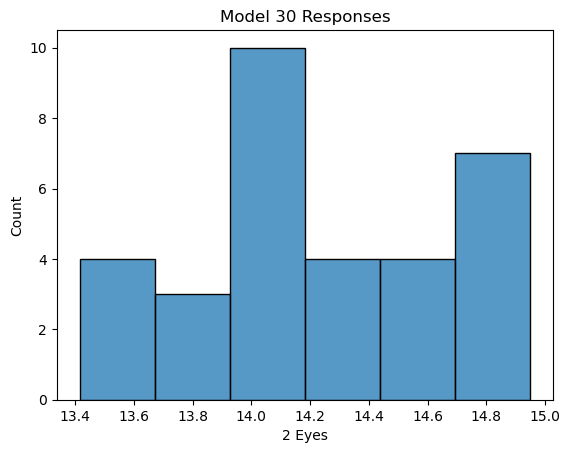

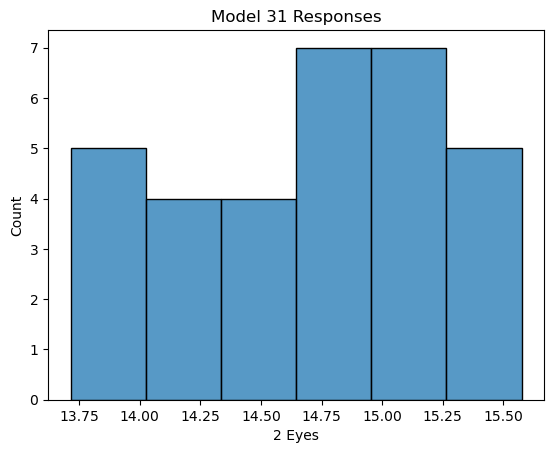

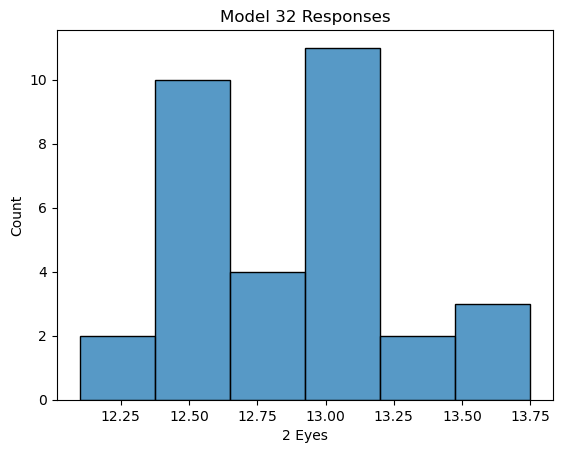

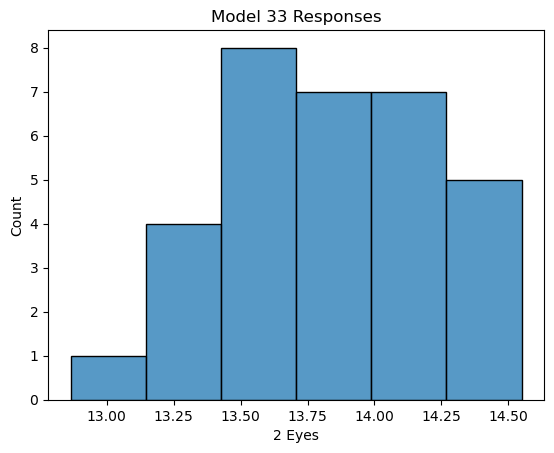

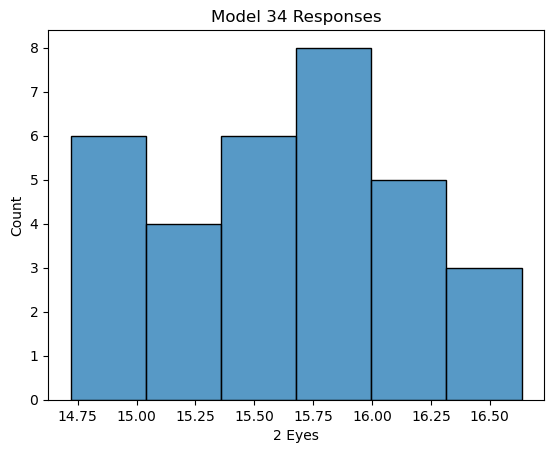

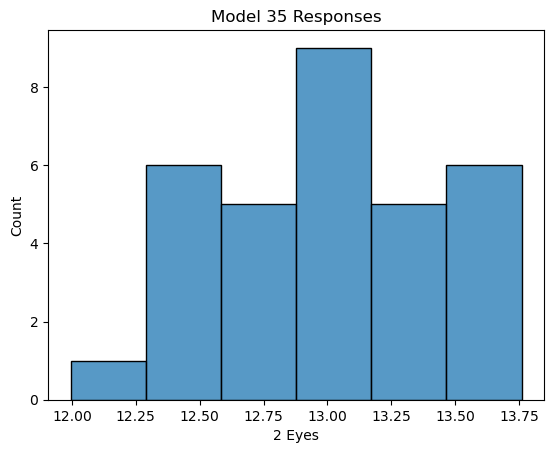

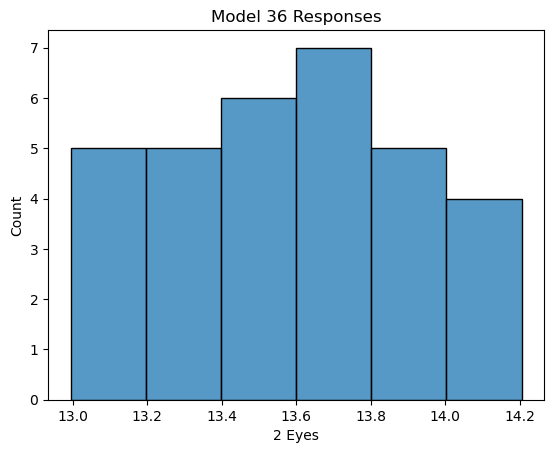

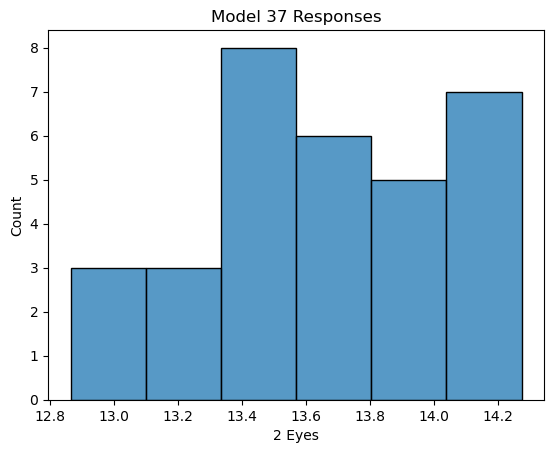

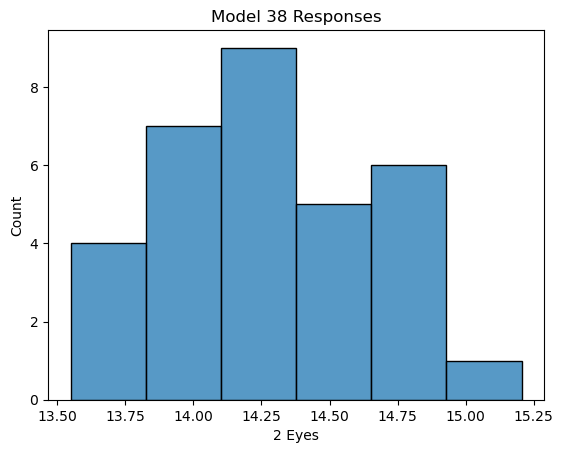

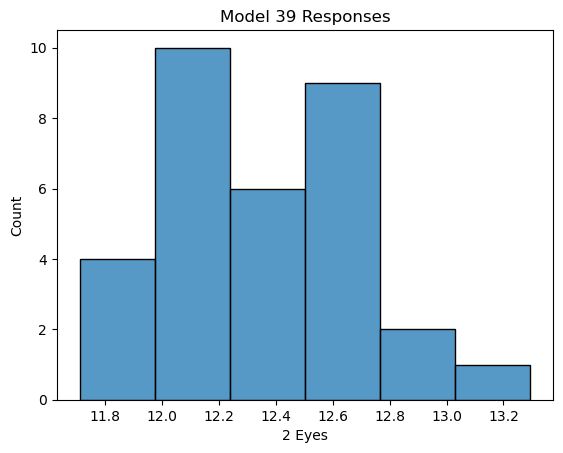

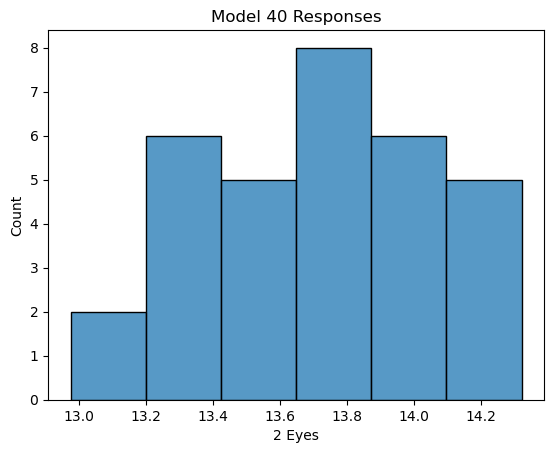

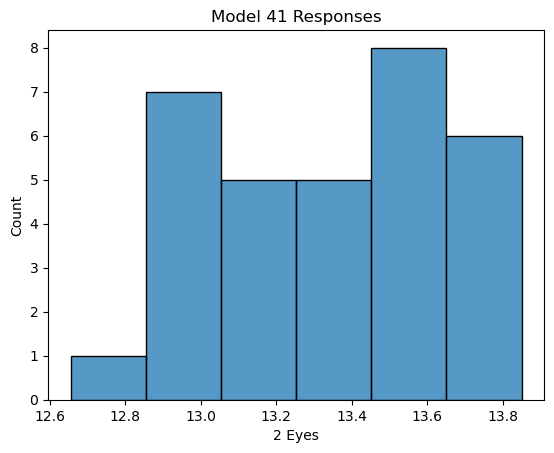

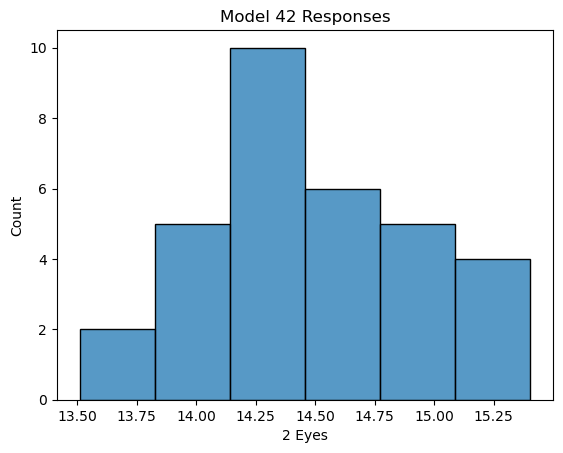

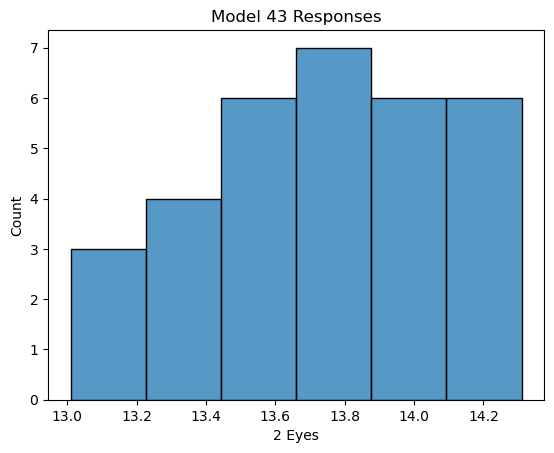

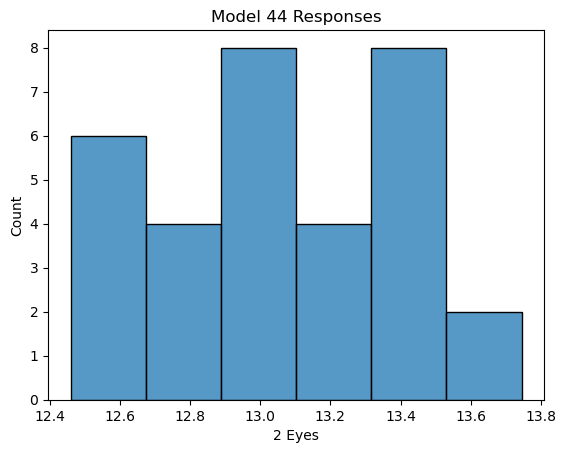

In [9]:
for i in range(population_size):
    series = extract_population_response(df_feature_combination, i, "2 Eyes")
    plt.figure()
    plt.title(f"Model {i} Responses")
    sns.histplot(series)
    plt.show()

# ANOVA

In [10]:
df_anova = pd.melt(df_mean_responses.reset_index(), id_vars=['model_idx'], value_vars=df_feature_combination.columns)
df_anova.columns = ["model_idx", "feature_combination", "mean"]
df_anova.head()

model_idx feature_combination       mean
0          0               1 Eye  15.022188
1          1               1 Eye  15.276094
2          2               1 Eye  15.157500
3          3               1 Eye  16.957500
4          4               1 Eye  14.797187

In [11]:
res = pg.rm_anova(data=df_anova, dv='mean', within='feature_combination', subject='model_idx', 
                  correction=True, detailed=True)
res

Source          SS   DF         MS           F          p-unc  \
0  feature_combination  438.258338    7  62.608334  655.884366  7.032661e-181   
1                Error   29.400559  308   0.095456         NaN            NaN   

      p-GG-corr       ng2       eps sphericity        W-spher  p-spher  
0  1.851172e-69  0.658926  0.374624       True  117828.514097      1.0  
1           NaN       NaN       NaN        NaN            NaN      NaN

## Check Assumptions for ANOVA

In [12]:
pg.sphericity(data=df_anova, dv='mean', within='feature_combination', subject='model_idx')

SpherResults(spher=True, W=117828.5140970909, chi2=-484.0388544744033, dof=27, pval=1.0)

In [13]:
pg.normality(data=df_anova, dv='mean', group='feature_combination')

W      pval  normal
feature_combination                            
1 Eye                0.965664  0.200260    True
2 Eyes               0.927724  0.007801   False
1 Eye, Nose          0.978413  0.556800    True
1 Eye, Mouth         0.976718  0.493095    True
2 Eyes, Nose         0.967010  0.224850    True
1 Eye, Nose, Mouth   0.977985  0.540330    True
Full Face            0.978656  0.566282    True
2 Eyes, Mouth        0.966466  0.214591    True

## Pairwise t-Tests

In [14]:
post_hocs = pg.pairwise_tests(data=df_anova, dv='mean', within='feature_combination', subject='model_idx', 
                              padjust='bonf', alternative='greater')
post_hocs[post_hocs.B=="Full Face"]
post_hocs

/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:7321: RuntimeWarning: invalid value encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)


Contrast                   A                   B  Paired  \
0   feature_combination               1 Eye        1 Eye, Mouth    True   
1   feature_combination               1 Eye         1 Eye, Nose    True   
2   feature_combination               1 Eye  1 Eye, Nose, Mouth    True   
3   feature_combination               1 Eye              2 Eyes    True   
4   feature_combination               1 Eye       2 Eyes, Mouth    True   
5   feature_combination               1 Eye        2 Eyes, Nose    True   
6   feature_combination               1 Eye           Full Face    True   
7   feature_combination        1 Eye, Mouth         1 Eye, Nose    True   
8   feature_combination        1 Eye, Mouth  1 Eye, Nose, Mouth    True   
9   feature_combination        1 Eye, Mouth              2 Eyes    True   
10  feature_combination        1 Eye, Mouth       2 Eyes, Mouth    True   
11  feature_combination        1 Eye, Mouth        2 Eyes, Nose    True   
12  feature_combination        1 Eye, Mouth           Full Face    True   
13  feature_combination         1 Eye, Nose  1 Eye, Nose, Mouth    True   
14  feature_combination         1 Eye, Nose              2 Eyes    True   
15  feature_combination         1 Eye, Nose       2 Eyes, Mouth    True   
16  feature_combination         1 Eye, Nose        2 Eyes, Nose    True   
17  feature_combination         1 Eye, Nose           Full Face    True   
18  feature_combination  1 Eye, Nose, Mouth              2 Eyes    True   
19  feature_combination  1 Eye, Nose, Mouth       2 Eyes, Mouth    True   
20  feature_combination  1 Eye, Nose, Mouth        2 Eyes, Nose    True   
21  feature_combination  1 Eye, Nose, Mouth           Full Face    True   
22  feature_combination              2 Eyes       2 Eyes, Mouth    True   
23  feature_combination              2 Eyes        2 Eyes, Nose    True   
24  feature_combination              2 Eyes           Full Face    True   
25  feature_combination       2 Eyes, Mouth        2 Eyes, Nose    True   
26  feature_combination       2 Eyes, Mouth           Full Face    True   
27  feature_combination        2 Eyes, Nose           Full Face    True   

    Parametric          T   dof alternative         p-unc        p-corr  \
0         True  27.051838  44.0     greater  2.345681e-29  6.567907e-28   
1         True  20.773277  44.0     greater  1.134766e-24  3.177344e-23   
2         True  33.855315  44.0     greater  1.892327e-33  5.298517e-32   
3         True  24.805446  44.0     greater  8.453295e-28  2.366923e-26   
4         True  35.331875  44.0     greater  3.087205e-34  8.644173e-33   
5         True  30.541833  44.0     greater  1.467169e-31  4.108075e-30   
6         True  39.183557  44.0     greater  3.732582e-36  1.045123e-34   
7         True -10.887284  44.0     greater  1.000000e+00  1.000000e+00   
8         True  21.228259  44.0     greater  4.760414e-25  1.332916e-23   
9         True  -0.001198  44.0     greater  5.004750e-01  1.000000e+00   
10        True  25.773302  44.0     greater  1.744606e-28  4.884898e-27   
11        True   8.995476  44.0     greater  7.873585e-12  2.204604e-10   
12        True  30.933597  44.0     greater  8.580829e-32  2.402632e-30   
13        True  27.182092  44.0     greater  1.921104e-29  5.379090e-28   
14        True  10.923466  44.0     greater  2.043762e-14  5.722535e-13   
15        True  25.352119  44.0     greater  3.444438e-28  9.644427e-27   
16        True  25.492171  44.0     greater  2.744169e-28  7.683674e-27   
17        True  35.629426  44.0     greater  2.160758e-34  6.050121e-33   
18        True  -9.678670  44.0     greater  1.000000e+00  1.000000e+00   
19        True  11.700302  44.0     greater  2.121850e-15  5.941180e-14   
20        True   0.117593  44.0     greater  4.534625e-01  1.000000e+00   
21        True  26.349275  44.0     greater  6.990398e-29  1.957312e-27   
22        True  27.272044  44.0     greater  1.674479e-29  4.688541e-28   
23        True  21.456210  44.0     gre

# 1 Parafoveal Feature

In [15]:
results = pairwise_anova(df_anova, ["2 Eyes", "1 Eye, Nose", "1 Eye, Mouth"], 
                         dv='mean', within='feature_combination', subject='model_idx', 
                         correction=True, detailed=True)

In [16]:
for result in results:
    print(f"{result[0]} and {result[1]} gives")
    try:
        print("\t", result[2]["p-GG-corr"][0])
    except:
        print("\t", result[2]["p-unc"][0])

2 Eyes and 1 Eye, Nose gives
	 4.0875247425878856e-14
2 Eyes and 1 Eye, Mouth gives
	 0.9990499062464758
1 Eye, Nose and 1 Eye, Mouth gives
	 4.5509892707023604e-14


# 2 Parafoveal Features

In [17]:
results = pairwise_anova(df_anova, ["2 Eyes, Nose", "1 Eye, Nose, Mouth", "2 Eyes, Mouth"], 
                         dv='mean', within='feature_combination', subject='model_idx', 
                         correction=True, detailed=True)

In [18]:
for result in results:
    print(f"{result[0]} and {result[1]} gives")
    try:
        print("\t", result[2]["p-GG-corr"][0])
    except:
        print("\t", result[2]["p-unc"][0])

2 Eyes, Nose and 1 Eye, Nose, Mouth gives
	 0.9069249623007876
2 Eyes, Nose and 2 Eyes, Mouth gives
	 2.604758831984089e-14
1 Eye, Nose, Mouth and 2 Eyes, Mouth gives
	 4.243699737864664e-15


# Parafoveal Feature Count

In [19]:
df_parafoveal = pd.DataFrame(0, index=np.arange(population_size), columns=["0 Parafoveal Features",
                                                                          "1 Parafoveal Features",
                                                                          "2 Parafoveal Features",
                                                                          "3 Parafoveal Features",
                                                                          "model_idx"])
for model_idx in range(population_size):
    df_parafoveal.at[model_idx, "0 Parafoveal Features"] = df_mean_responses["1 Eye"].iloc[model_idx]
    df_parafoveal.at[model_idx, "1 Parafoveal Features"] = df_mean_responses[["2 Eyes", "1 Eye, Nose", "1 Eye, Mouth"]].iloc[model_idx].mean()
    df_parafoveal.at[model_idx, "2 Parafoveal Features"] = df_mean_responses[["2 Eyes, Nose", "1 Eye, Nose, Mouth", "2 Eyes, Mouth"]].iloc[model_idx].mean()
    df_parafoveal.at[model_idx, "3 Parafoveal Features"] = df_mean_responses["Full Face"].iloc[model_idx]
    df_parafoveal.at[model_idx, "model_idx"] = model_idx

In [20]:
df_parafoveal.head()

0 Parafoveal Features  1 Parafoveal Features  2 Parafoveal Features  \
0              15.022188              13.378177              12.048333   
1              15.276094              13.482917              12.055990   
2              15.157500              13.591094              12.302760   
3              16.957500              14.894896              13.263750   
4              14.797187              13.352604              12.162083   

   3 Parafoveal Features  model_idx  
0              10.950937          0  
1              10.910000          1  
2              11.240937          2  
3              11.980937          3  
4              11.175469          4

## Anova

In [21]:
df_parafoveal_anova = pd.melt(df_parafoveal.reset_index(), id_vars=['model_idx'], value_vars=df_parafoveal.columns)
df_parafoveal_anova.columns = ["model_idx", "parafovea", "mean"]
df_parafoveal_anova.head()

model_idx              parafovea       mean
0          0  0 Parafoveal Features  15.022188
1          1  0 Parafoveal Features  15.276094
2          2  0 Parafoveal Features  15.157500
3          3  0 Parafoveal Features  16.957500
4          4  0 Parafoveal Features  14.797187

In [22]:
res = pg.rm_anova(data=df_parafoveal_anova, dv='mean', within='parafovea', subject='model_idx', 
                  correction=True, detailed=True)
res

Source          SS   DF          MS            F          p-unc  \
0  parafovea  341.189510    3  113.729837  1515.533207  4.884195e-102   
1      Error    9.905648  132    0.075043          NaN            NaN   

      p-GG-corr       ng2       eps sphericity     W-spher  p-spher  
0  8.103540e-36  0.754158  0.334187       True  534.090997      1.0  
1           NaN       NaN       NaN        NaN         NaN      NaN

## Check Assumptions

In [23]:
pg.sphericity(data=df_parafoveal_anova, dv='mean', within='parafovea', subject='model_idx')

SpherResults(spher=True, W=534.0909968795639, chi2=-268.31974618440375, dof=5, pval=1.0)

In [24]:
pg.normality(data=df_parafoveal_anova, dv='mean', group='parafovea')

W      pval  normal
parafovea                                        
0 Parafoveal Features  0.965664  0.200260    True
1 Parafoveal Features  0.966099  0.207922    True
2 Parafoveal Features  0.970837  0.310424    True
3 Parafoveal Features  0.978656  0.566282    True

## Pairwise t-Tests

In [25]:
post_hocs = pg.pairwise_tests(data=df_parafoveal_anova, dv='mean', within='parafovea', subject='model_idx', 
                              padjust='bonf', alternative='greater')
post_hocs[post_hocs.B=="3 Parafoveal Features"]
post_hocs

Contrast                      A                      B  Paired  \
0  parafovea  0 Parafoveal Features  1 Parafoveal Features    True   
1  parafovea  0 Parafoveal Features  2 Parafoveal Features    True   
2  parafovea  0 Parafoveal Features  3 Parafoveal Features    True   
3  parafovea  1 Parafoveal Features  2 Parafoveal Features    True   
4  parafovea  1 Parafoveal Features  3 Parafoveal Features    True   
5  parafovea  2 Parafoveal Features  3 Parafoveal Features    True   

   Parametric          T   dof alternative         p-unc        p-corr  \
0        True  34.017243  44.0     greater  1.545608e-33  9.273650e-33   
1        True  36.654677  44.0     greater  6.453391e-35  3.872035e-34   
2        True  39.183557  44.0     greater  3.732582e-36  2.239549e-35   
3        True  40.293266  44.0     greater  1.128514e-36  6.771081e-36   
4        True  43.360186  44.0     greater  4.835498e-38  2.901299e-37   
5        True  47.671514  44.0     greater  8.129127e-40  4.877476e-39   

  p-adjust       BF10    hedges  
0     bonf  1.353e+30  1.566805  
1     bonf  2.999e+31  3.055048  
2     bonf  4.841e+32  4.346532  
3     bonf  1.556e+33  1.616307  
4     bonf  3.369e+34  3.091613  
5     bonf  1.819e+36  1.560068

## Pairwise ANOVA

In [30]:
results = pairwise_anova(df_parafoveal_anova, ['0 Parafoveal Features', '1 Parafoveal Features',
                         '2 Parafoveal Features', '3 Parafoveal Features'], 
                         dv='mean', within='parafovea', subject='model_idx', 
                         correction=True, detailed=True)

In [31]:
for result in results:
    print(f"{result[0]} and {result[1]} gives")
    try:
        print("\t", result[2]["p-GG-corr"][0])
    except:
        print("\t", result[2]["p-unc"][0])

0 Parafoveal Features and 1 Parafoveal Features gives
	 2.7801855065988087e-35
0 Parafoveal Features and 2 Parafoveal Features gives
	 1.2308130088991985e-36
0 Parafoveal Features and 3 Parafoveal Features gives
	 8.080354742292325e-38
1 Parafoveal Features and 2 Parafoveal Features gives
	 2.0994755414423397e-38
1 Parafoveal Features and 3 Parafoveal Features gives
	 1.0590322258848192e-39
2 Parafoveal Features and 3 Parafoveal Features gives
	 2.1208538143108464e-41
